Connect and Mount drive 

In [ ]:
import os
from google.colab import drive

# drive.mount("/content/gdrive/", force_remount=True)
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


PATH 

In [ ]:
PROJECT_GDRIVE = "/content/gdrive/MyDrive/ColabNotebooks/GroupProject"
CUSTOM_MODEL_NAME = "AgeGenderPrediction"

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join(PROJECT_GDRIVE, 'workspace'),
    'DATASET_PATH': os.path.join(PROJECT_GDRIVE, 'workspace','dataset'),
    'MODEL_PATH': os.path.join(PROJECT_GDRIVE, 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join(PROJECT_GDRIVE, 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join(PROJECT_GDRIVE, 'workspace','models',CUSTOM_MODEL_NAME),
    'LOGS_PATH': os.path.join(PROJECT_GDRIVE, 'workspace','logs',CUSTOM_MODEL_NAME), 
 }

Extract dataset

In [ ]:
# !cd {paths['DATASET_PATH']} && tar -xzvf UTKFace.tar.gz


In [ ]:
#download from http://dlib.net/files/
#download from https://github.com/rcmalli/keras-vggface/releases

files = {
    'PRETRAINED_MODEL': os.path.join(paths['PRETRAINED_MODEL_PATH'], 'rcmalli_vggface_tf_notop_resnet50.h5'),
    'FACE_DETECTOR': os.path.join(paths['WORKSPACE_PATH'], 'mmod_human_face_detector.dat'),
    'LANDMARK_PREDICTOR': os.path.join(paths['WORKSPACE_PATH'], 'shape_predictor_68_face_landmarks.dat'),
}

Download pretrain model to ~/.keras/models

In [ ]:
# from tensorflow import keras

# # Create the base model from the pre-trained model InceptionV3
# base_model = keras.applications.InceptionV3(input_shape=(200, 200, 3),
#                                                include_top=False, 
#                                                weights='imagenet')

import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dlib 
from keras.preprocessing import image
from PIL import Image, ImageFile
# import PIL.Image
# from PIL import ImageFile

In [ ]:
from tensorflow.keras import backend as K

def preprocess_input_resnet50(x):
    x_temp = np.copy(x)
    
    # mean subtraction
    # already BGR in opencv
    #x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91
    x_temp[..., 1] -= 103
    x_temp[..., 2] -= 131
    
    return x_temp

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras.applications import imagenet_utils
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_source_inputs
import warnings
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def resnet_identity_block(input_tensor, kernel_size, filters, stage, block,
                          bias=False):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv1_reduce_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_reduce"
    conv1_increase_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_increase"
    conv3_name = 'conv' + str(stage) + "_" + str(block) + "_3x3"

    x = Conv2D(filters1, (1, 1), use_bias=bias, name=conv1_reduce_name)(
        input_tensor)
    x = BatchNormalization(axis=bn_axis, name=conv1_reduce_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, use_bias=bias,
               padding='same', name=conv3_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv3_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), use_bias=bias, name=conv1_increase_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv1_increase_name + "/bn")(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def resnet_conv_block(input_tensor, kernel_size, filters, stage, block,
                      strides=(2, 2), bias=False):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv1_reduce_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_reduce"
    conv1_increase_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_increase"
    conv1_proj_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_proj"
    conv3_name = 'conv' + str(stage) + "_" + str(block) + "_3x3"

    x = Conv2D(filters1, (1, 1), strides=strides, use_bias=bias,
               name=conv1_reduce_name)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=conv1_reduce_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=bias,
               name=conv3_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv3_name + "/bn")(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv1_increase_name, use_bias=bias)(x)
    x = BatchNormalization(axis=bn_axis, name=conv1_increase_name + "/bn")(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, use_bias=bias,
                      name=conv1_proj_name)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=conv1_proj_name + "/bn")(
        shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def RESNET50(include_top=True, weights='vggface',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=8631):
    input_shape = imagenet_utils.obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(
        64, (7, 7), use_bias=False, strides=(2, 2), padding='same',
        name='conv1/7x7_s2')(img_input)
    x = BatchNormalization(axis=bn_axis, name='conv1/7x7_s2/bn')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = resnet_conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = resnet_identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = resnet_identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    x = resnet_conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = resnet_identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = resnet_identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = resnet_identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    x = resnet_conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = resnet_identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = resnet_identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = resnet_identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = resnet_identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = resnet_identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    x = resnet_conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = resnet_identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = resnet_identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='classifier')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vggface_resnet50')

    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import tensorflow as tf
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.inception_v3 import InceptionV3

BASE_WEIGHTS_PATH=files['PRETRAINED_MODEL']

#     create model resnet50
base_model = RESNET50(input_shape=(200, 200, 3), include_top=False, weights=None, pooling='avg')
# load pre-trained weights if used for fine-tuning

base_model.load_weights(BASE_WEIGHTS_PATH)
#only 50 last layer that trainable 
for layer in base_model.layers[:len(base_model.layers)-50]:
    layer.trainable = False

base_output = base_model.output

#add to predict Age and gender
# age 0~6 categorical, treat age as classifications task
output_a = Dense(7, activation='softmax', name='predications_age')(base_output)
# gender 0 or 1
output_g = Dense(2, activation='softmax', name='predications_gender')(base_output)

new_model = Model(inputs=base_model.input, outputs=[output_a, output_g], name='network_based_vggface')

In [ ]:
new_model.summary()

Model: "network_based_vggface"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 100, 100, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 100, 100, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                             

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
import time

# config for training
batch_size=128
nb_epochs=30
initial_lr=0.001
val_split=0.2
test_split=0.2

train_data_path = paths['DATASET_PATH'] + '/UTKFace'
weights_output_path = paths['CHECKPOINT_PATH']

# learning rate schedule
class Schedule:
    def __init__(self, nb_epochs, initial_lr):
        self.epochs = nb_epochs
        self.initial_lr = initial_lr

    def __call__(self, epoch_idx):
        if epoch_idx < self.epochs * 0.25:
            return self.initial_lr
        elif epoch_idx < self.epochs * 0.50:
            return self.initial_lr * 0.2
        elif epoch_idx < self.epochs * 0.75:
            return self.initial_lr * 0.04
        return self.initial_lr * 0.008

# load train data from disk
def load_data():
    #for image
    x = []
    #for age
    y_a = []
    #for gender
    y_g = []

    # loop the images
    root_path, dirs, files = next(os.walk(train_data_path))

    for f in files:
        f_items = str(f).split('_')
        if len(f_items) == 4 and int(f_items[0]) <= 116:
            image = cv2.imread(os.path.join(root_path, f))
            image = cv2.resize(image, (200, 200))
            x.append(image)
            #age
#             age_labels = ['<1','1-12','13-17','18-30', '31-45', '46-64', '>=65']
            age = int(f_items[0])    
#             if age>=1 and age<=2:
#                 y_a.append(0)
#             elif age>=3 and age<=9:
#                 y_a.append(1)
#             elif age>=10 and age<=20:
#                 y_a.append(2)
#             elif age>=21 and age<=27:
#                 y_a.append(3)
#             elif age>=28 and age<=45:
#                 y_a.append(4)
#             elif age>=46 and age<=65:
#                 y_a.append(5)
#             elif age>=66 and age<=116:
#                 y_a.append(6)
            if age<1:
                y_a.append(0)
            elif age>=1 and age<=12:
                y_a.append(1)
            elif age>=13 and age<=17:
                y_a.append(2)
            elif age>=18 and age<=30:
                y_a.append(3)
            elif age>=31 and age<=45:
                y_a.append(4)
            elif age>=46 and age<=64:
                y_a.append(5)
            elif age>=65:
                y_a.append(6)
            #gender
            y_g.append(int(f_items[1]))
    
    #one-hot encoded https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
    y_a = utils.to_categorical(y_a, 7)
    y_g = utils.to_categorical(y_g, 2)
    
    x = np.array(x)
    y_a = np.array(y_a)
    y_g = np.array(y_g)

    # shuffle the indexs
    indexs = np.arange(len(x))
    np.random.shuffle(indexs)
    
    x = x[indexs]
    y_a = y_a[indexs]
    y_g = y_g[indexs]

    # preprocess
    # x = tf.keras.applications.resnet50.preprocess_input(x)
    x = preprocess_input_resnet50(x)
    
    return x, y_a, y_g


'''
fine-tuning with UTKFace dataset
'''
def train(model):
    x, y_a, y_g = load_data()
    print(x.shape)
    print(y_a.shape)
    print(y_g.shape)
    
    train_index = int(len(x)*(1-test_split))

    x_train = x[:train_index]
    y_train_a = y_a[:train_index]
    y_train_g = y_g[:train_index]

    x_test = x[train_index:]
    y_test_a = y_a[train_index:]
    y_test_g = y_g[train_index:]

    #set optimizer Adam
    opt = Adam(learning_rate=initial_lr)
    
    # config the model with losses and metrics
    model.compile(optimizer=opt, loss=['categorical_crossentropy','categorical_crossentropy'],
                  metrics=['accuracy'])    

    callbacks = [LearningRateScheduler(schedule=Schedule(nb_epochs, initial_lr)),
                ModelCheckpoint(weights_output_path + "/face_weights.{epoch:02d}"
                                    "-val_loss-{val_loss:.2f}-val_age_loss-{val_predications_age_loss:.2f}"
                                    "-val_gender_loss-{val_predications_gender_loss:.2f}.utk.h5",
                                monitor="val_loss",
                                verbose=1,
                                save_best_only=True,
                                mode="auto")
                ]
    
    #train the model
    history = model.fit(x_train, [y_train_a, y_train_g],
                        batch_size=batch_size, epochs=nb_epochs, 
                        callbacks=callbacks, validation_data=(x_test, [y_test_a, y_test_g]))

    return history

In [ ]:
myHistory = train(new_model)

(23705, 200, 200, 3)
(23705, 7)
(23705, 2)
Epoch 1/30
149/149 [==============================] - ETA: 0s - loss: 1.6784 - predications_age_loss: 1.1931 - predications_gender_loss: 0.4853 - predications_age_accuracy: 0.5446 - predications_gender_accuracy: 0.8159
Epoch 1: val_loss improved from inf to 1.96472, saving model to /content/gdrive/MyDrive/ColabNotebooks/GroupProject/workspace/models/AgeGenderPrediction/face_weights.01-val_loss-1.96-val_age_loss-1.33-val_gender_loss-0.64.utk.h5
149/149 [==============================] - 96s 495ms/step - loss: 1.6784 - predications_age_loss: 1.1931 - predications_gender_loss: 0.4853 - predications_age_accuracy: 0.5446 - predications_gender_accuracy: 0.8159 - val_loss: 1.9647 - val_predications_age_loss: 1.3257 - val_predications_gender_loss: 0.6390 - val_predications_age_accuracy: 0.5263 - val_predications_gender_accuracy: 0.8395 - lr: 0.0010
Epoch 2/30
149/149 [==============================] - ETA: 0s - loss: 1.1806 - predications_age_loss: 0.

In [ ]:
# save history
np.save('history20230317b.npy',myHistory.history)

In [ ]:
# load history
history1=np.load('history20230317b.npy',allow_pickle='TRUE').item()

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, type):
    plotting_data_dict = history
    plt.figure(figsize=(12,8))
    test_loss = plotting_data_dict['val_predications_'+str(type)+'_loss']
    training_loss = plotting_data_dict['predications_'+str(type)+'_loss']
    test_accuracy = plotting_data_dict['val_predications_'+str(type)+'_accuracy']
    training_accuracy = plotting_data_dict['predications_'+str(type)+'_accuracy']
    epochs = range(1,len(test_loss)+1)
    plt.subplot(121)
    plt.plot(epochs,test_loss,marker='X',label='test_predications_'+str(type)+'_loss')
    plt.plot(epochs,training_loss,marker='X',label='predications_'+str(type)+'_loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(epochs,test_accuracy,marker='X',label='test_predications_'+str(type)+'_accuracy')
    plt.plot(epochs,training_accuracy,marker='X',label='training_predications_'+str(type)+'_accuracy')
    plt.legend()

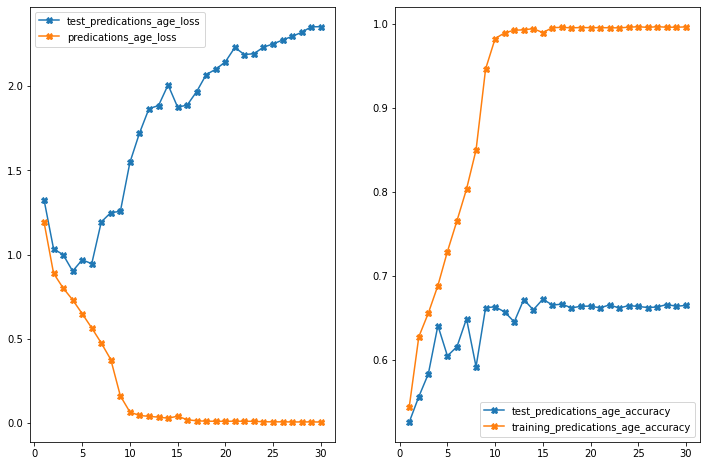

In [ ]:
plot_history(myHistory.history, "age")

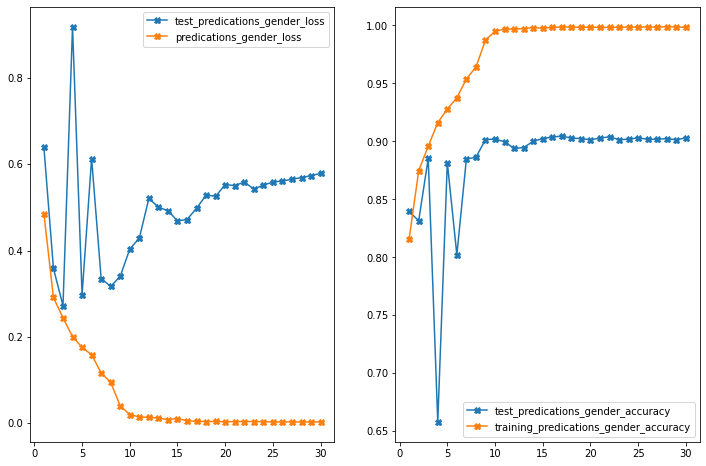

In [ ]:
plot_history(myHistory.history, "gender")